In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
import scipy.sparse as sp
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

plt.rcParams['font.size'] = 12

# Load data

## sc  data  can  download from https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-Isocortex-1-raw.h5ad

In [2]:
sc_data = sc.read('../datas/mouse_brain_stereo_seq/WMB_10Xv3_Isocortex_1_scrna.h5ad')

meta = pd.read_csv('../datas/mouse_brain_stereo_seq/scrna_cell_metadata.csv', index_col=0)

sc_data = sc_data[sc_data.obs_names.isin(meta.index), ].copy()

sc_data.obs = meta.loc[sc_data.obs_names, ]

cluster_info = pd.read_excel('../datas/mouse_brain_stereo_seq/scrna_cl.df_CCN202307220.xlsx')
cluster_info = cluster_info.loc[cluster_info.cl.isin(sc_data.obs.cluster_alias.tolist()), ]

sc_data

AnnData object with n_obs × n_vars = 227670 × 32285
    obs: 'cell_barcode', 'barcoded_cell_sample_label', 'library_label', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'abc_sample_id'
    var: 'gene_symbol'

In [3]:
sc_data.obs['cell_type'] = sc_data.obs['cluster_alias']
sc_data.obs['cell_type'] = sc_data.obs['cell_type'].replace(dict(zip(cluster_info.cl.tolist(), 
                                                                     cluster_info.subclass_label.tolist())))

In [4]:
sp_data = sc.read('../datas/mouse_brain_stereo_seq/mouse_isocortex_region/SS200000128TR_E2_stereo_seq_isocortex_spatial.h5ad')
sp_data

AnnData object with n_obs × n_vars = 10093 × 24233
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'right_hemisphere', 'region', 'broad_region', 'slice', 'layer', 'SpCAST_predicted'
    obsm: 'spatial'

In [5]:
sp_data.obs['my_region'] = sp_data.obs.region.str.replace(r'(1|2/3|4|5|6)', '_', regex=True)
sp_data.obs['my_region'] = sp_data.obs.my_region.map(lambda x: x.split("_")[0])
cortex_mapping = {
    "AUDd": "Auditory Cortex",
    "AUDpo": "Auditory Cortex",
    "ECT": "Ectorhinal Cortex",
    "PERI": "Perirhinal Cortex",
    "PTLp": "Posterior Parietal Cortex",
    "RSPagl": "Retrosplenial Cortex",
    "RSPd": "Retrosplenial Cortex",
    "RSPv": "Retrosplenial Cortex",
    "RSPv2": "Retrosplenial Cortex",
    "TEa": "Temporal Association Cortex",
    "VISal": "Visual Cortex",
    "VISam": "Visual Cortex",
    "VISp": "Visual Cortex"
}
sp_data.obs['my_region'] = sp_data.obs['my_region'].replace(cortex_mapping)

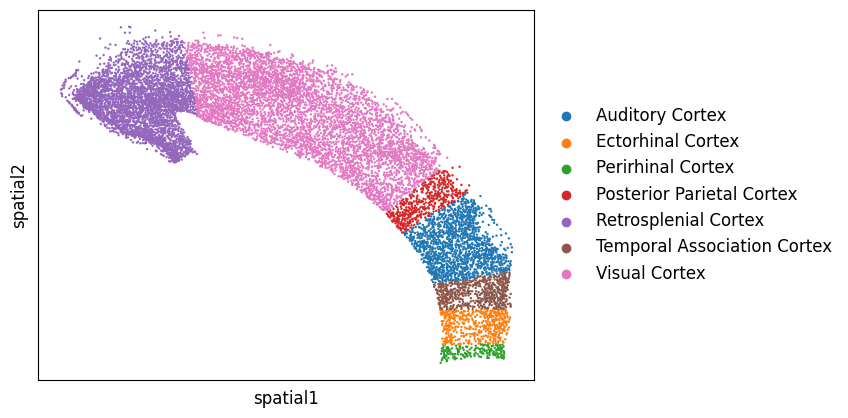

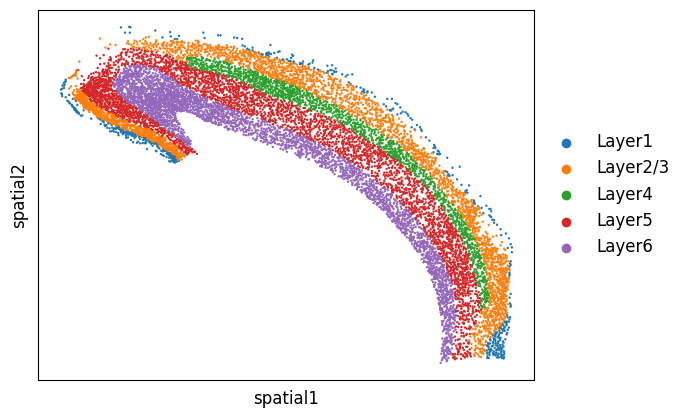

In [6]:
sc.pl.embedding(sp_data, basis='spatial', color='my_region', title=''), 
sc.pl.embedding(sp_data, basis='spatial', color='layer', title='')

# Process data

In [7]:
sc_data.var.set_index('gene_symbol', inplace=True)

sc_data.var_names = sc_data.var_names.astype(str)

In [8]:
sc_data.var_names_make_unique()
sp_data.var_names_make_unique()

In [9]:
# Convert to row-sparse matrix
if not sp.issparse(sc_data.X):
    sc_data.X = sp.csr_matrix(sc_data.X)
    
if not sp.issparse(sp_data.X):
    temp = sp.csr_matrix(np.array(sp_data.X)).copy()
    del sp_data.X
    sp_data.X = temp.copy()
    del temp

In [10]:
sc_data.X = sc_data.X.astype(np.float32)
sp_data.X = sp_data.X.astype(np.float32)

In [11]:
# Please make sure cell_type is included in scRNA_data.obs
assert 'cell_type' in sc_data.obs

In [12]:
# Filter rare cell types: cell types with fewer than 100 cells
cell_type_counts = sc_data.obs['cell_type'].value_counts()
valid_cell_types = cell_type_counts[cell_type_counts >= 100].index
sc_data = sc_data[sc_data.obs['cell_type'].isin(valid_cell_types)].copy()

# Output results
print(f"Number of cell types in the original dataset: {cell_type_counts.shape[0]}")
print(f"Number of cell types after filtering: {len(sc_data.obs['cell_type'].unique())}")

Number of cell types in the original dataset: 112
Number of cell types after filtering: 31


In [13]:
cell_type_counts

L6 CT CTX Glut            44705
L4/5 IT CTX Glut          44121
L2/3 IT CTX Glut          41389
L5 NP CTX Glut            10451
L6 IT CTX Glut             9627
                          ...  
LA-BLA-BMA-PA Glut            1
L5 PPP Glut                   1
PAS-MV Ebf2 Gly-Gaba          1
NP PPP Glut                   1
TMv-PMv Tbx3 Hist-Gaba        1
Name: cell_type, Length: 112, dtype: int64

In [14]:
re_map = {
    'CLA-EPd-CTX Car3 Glut': 'CLA-EPd-CTX Car3 Glut',
    'L6 CT CTX Glut': 'L6',
    'L5 ET CTX Glut': 'L5',
    'L4/5 IT CTX Glut': 'L4/5',
    'L2/3 IT CTX Glut': 'L2/3',
    'L6b CTX Glut': 'L6',
    'L6 IT CTX Glut': 'L6',
    'IT EP-CLA Glut': 'IT EP-CLA Glut',
    'Astro-TE NN': 'Astro',
    'L5 IT CTX Glut': 'L5',
    'Sst Gaba': 'SST',
    'L5 NP CTX Glut': 'L5',
    'L5/6 IT TPE-ENT Glut': 'L5/6',
    'Lamp5 Gaba': 'LAMP5',
    'Sst Chodl Gaba': 'SST-CHODL',
    'VLMC NN': 'VLMC',
    'L2/3 IT RSP Glut': 'L2/3',
    'Oligo NN': 'Oligo',
    'ABC NN': 'ABC',
    'Vip Gaba': 'VIP',
    'Pvalb Gaba': 'PV',
    'L4 RSP-ACA Glut': 'L4',
    'Sncg Gaba': 'SNCG',
    'Endo NN': 'Endothelial',
    'Microglia NN': 'Microglia',
    'Peri NN': 'pericytes',
    'SMC NN': 'Smooth Muscle'
}

sc_data.obs['cell_type'] = sc_data.obs['cell_type'].replace(re_map)

# Run code

In [15]:
import sys
sys.path.append('../')

import SpCAST
from SpCAST.utils import preprocess_datasets

In [16]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

In [17]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

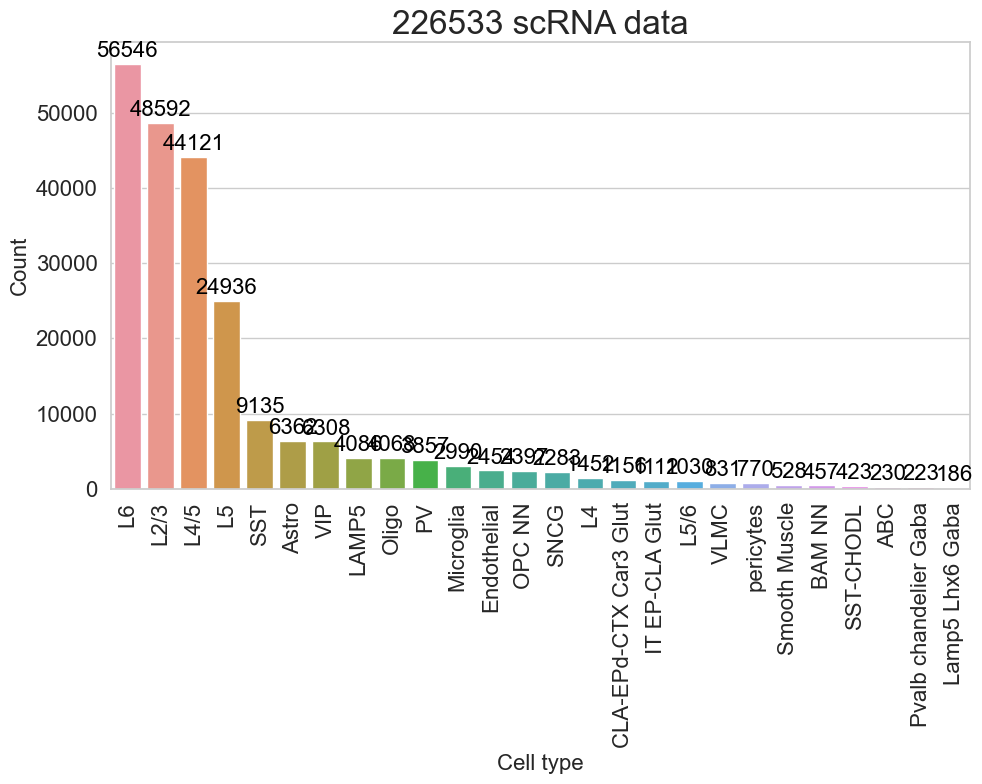

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Calculate the count for each category
sc_category_counts = scRNA_data.obs['cell_type'].value_counts().reset_index()
sc_category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10, 8))

# Draw barplot
ax = sns.barplot(x='Category', y='Count', data=sc_category_counts)

# Add title and labels
plt.title(f'{len(scRNA_data.obs)} scRNA data', fontsize=24)
plt.xlabel('Cell type', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=16)

# Increase font size for y-axis ticks
plt.yticks(fontsize=16)

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=16, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [19]:
datatype = 'Seq'

assert datatype in ['FISH', 'Seq']
scRNA_data, spRNA_data = preprocess_datasets(scRNA_data, spRNA_data, 
                                             hvg_num=50000, final_n_top_genes=2000, 
                                             min_genes_in_cells=3, datatype=datatype, include_markers=True)

Preprocessing scRNA-seq data ...
scRNA Data before filtering: 226533 cells  ||  scRNA Data after filtering: 226533 cells
Normalizing and log1p raw scRNA counts...
sc data nonzero expression ratio: 22.11%
-----------------------------------------------
Preprocessing spRNA-seq data ...
Normalizing and log1p raw spRNA counts...
-----------------------------------------------
Enhance spRNA Data expression ...


100%|█████████████████████████████████████████████████████████████████████████| 10093/10093 [00:00<00:00, 32453.14it/s]
Enhance gene expression data using spatial coordinates: 100%|██████████████████| 10093/10093 [00:07<00:00, 1378.06it/s]


sp data original nonzero expression ratio: 4.04%    sp data enhanced nonzero expression ratio: 8.67%
Concatenating datasets...
We have 16539 shared genes on scRNA and spatial RNA data
Computing scRNA data marker genes ...
We ultimately use 2282 genes for training ...
Preprocessing completed...


In [20]:
spRNA_data.obs = spRNA_data.obs.dropna(axis=1, how='all')

In [21]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

save_model_path='../model'
save_model_name='model_params.pth'

prob_df = SpCAST.train_SpCAST(scRNA_data=scRNA_data, spRNA_data=spRNA_data,
                              latent_dim1=30, latent_dim2=20, 
                              batch_size=256, loss_step=1, n_epochs=10, device=device, 
                              save_model_path=save_model_path, save_model_name=save_model_name)

Size of scRNA-seq data Input:  (226533, 2282)
Size of spRNA-seq data Input:  (10093, 2282)
Class distribution: [  230  6362   457  1156  2454  1112 48592  1452 44121 24936  1030 56546
  4086   186  2990  2397  4068  3857   223  2283  9135   423   528  6308
   831   770]
Class weights: [0.05250384 0.03262612 0.04663848 0.04051101 0.03660673 0.04073491
 0.02647962 0.03924361 0.02671861 0.0282245  0.04118422 0.0261128
 0.034363   0.05462472 0.03570347 0.03671723 0.03438125 0.03460295
 0.05280239 0.03694848 0.03133208 0.04723313 0.04556664 0.0326579
 0.04249776 0.04298454]
Train the model..........


Training:  10%|███████▎                                                                 | 1/10 [00:02<00:18,  2.11s/it]

Epoch:1 MMD Loss:11.781  Class Loss:58.244  Recon loss: 3287.398  Train_Accuracy: 71.85% 


Training:  20%|██████████████▌                                                          | 2/10 [00:03<00:15,  1.89s/it]

Epoch:2 MMD Loss:8.281  Class Loss:14.019  Recon loss: 2512.178  Train_Accuracy: 91.62% 


Training:  30%|█████████████████████▉                                                   | 3/10 [00:05<00:12,  1.81s/it]

Epoch:3 MMD Loss:7.431  Class Loss:7.775  Recon loss: 1650.346  Train_Accuracy: 94.56% 


Training:  40%|█████████████████████████████▏                                           | 4/10 [00:07<00:10,  1.77s/it]

Epoch:4 MMD Loss:6.893  Class Loss:5.771  Recon loss: 1279.683  Train_Accuracy: 95.70% 


Training:  50%|████████████████████████████████████▌                                    | 5/10 [00:09<00:08,  1.77s/it]

Epoch:5 MMD Loss:6.540  Class Loss:4.576  Recon loss: 1094.472  Train_Accuracy: 96.20% 


Training:  60%|███████████████████████████████████████████▊                             | 6/10 [00:10<00:07,  1.76s/it]

Epoch:6 MMD Loss:6.005  Class Loss:4.370  Recon loss: 1014.445  Train_Accuracy: 96.53% 


Training:  70%|███████████████████████████████████████████████████                      | 7/10 [00:12<00:05,  1.74s/it]

Epoch:7 MMD Loss:5.672  Class Loss:3.898  Recon loss: 963.877  Train_Accuracy: 96.80% 


Training:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [00:14<00:03,  1.73s/it]

Epoch:8 MMD Loss:5.328  Class Loss:3.634  Recon loss: 947.499  Train_Accuracy: 96.83% 


Training:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [00:15<00:01,  1.71s/it]

Epoch:9 MMD Loss:4.980  Class Loss:3.695  Recon loss: 935.461  Train_Accuracy: 96.83% 


Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]

Epoch:10 MMD Loss:4.778  Class Loss:3.562  Recon loss: 927.862  Train_Accuracy: 97.08% 
Testing the model..........



Testing scRNA data: 100%|████████████████████████████████████████████████████████████| 885/885 [00:09<00:00, 96.14it/s]


In [22]:
spRNA_data.obs['SpCAST_predicted_raw'] = spRNA_data.obs['SpCAST_predicted']

In [23]:
re_map = {
    'CLA-EPd-CTX Car3 Glut': 'CLA-EPd-CTX Car3 Glut',
    'L6 CT CTX Glut': 'L6',
    'L5 ET CTX Glut': 'L5',
    'L4/5 IT CTX Glut': 'L4/5',
    'L2/3 IT CTX Glut': 'L2/3',
    'L6b CTX Glut': 'L6',
    'L6 IT CTX Glut': 'L6',
    'IT EP-CLA Glut': 'IT EP-CLA Glut',
    'Astro-TE NN': 'Astro',
    'L5 IT CTX Glut': 'L5',
    'Sst Gaba': 'SST',
    'L5 NP CTX Glut': 'L5',
    'L5/6 IT TPE-ENT Glut': 'L5/6',
    'Lamp5 Gaba': 'LAMP5',
    'Sst Chodl Gaba': 'SST-CHODL',
    'VLMC NN': 'VLMC',
    'L2/3 IT RSP Glut': 'L2/3',
    'Oligo NN': 'Oligo',
    'ABC NN': 'ABC',
    'Vip Gaba': 'VIP',
    'Pvalb Gaba': 'PV',
    'L4 RSP-ACA Glut': 'L4',
    'Sncg Gaba': 'SNCG',
    'Endo NN': 'Endothelial',
    'Microglia NN': 'Microglia',
    'Peri NN': 'pericytes',
    'SMC NN': 'Smooth Muscle'
}

spRNA_data.obs['SpCAST_predicted'] = spRNA_data.obs['SpCAST_predicted'].replace(re_map)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

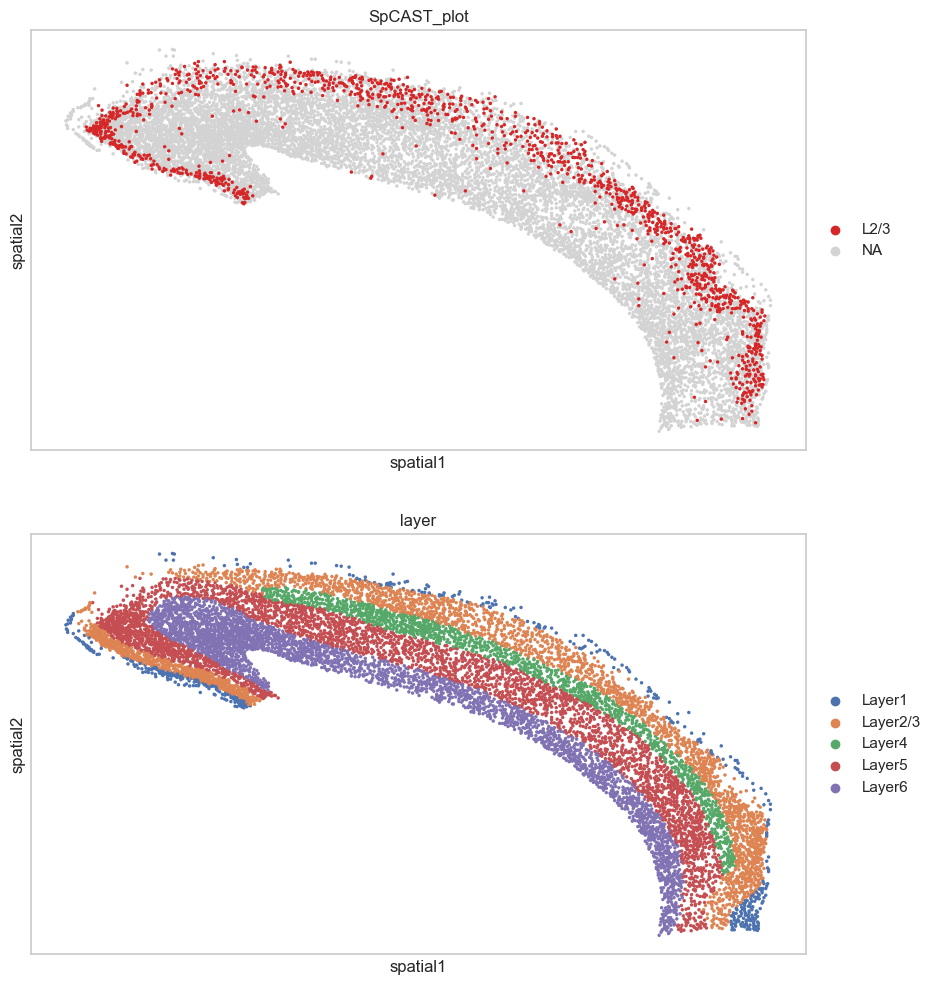

 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.98it/s]

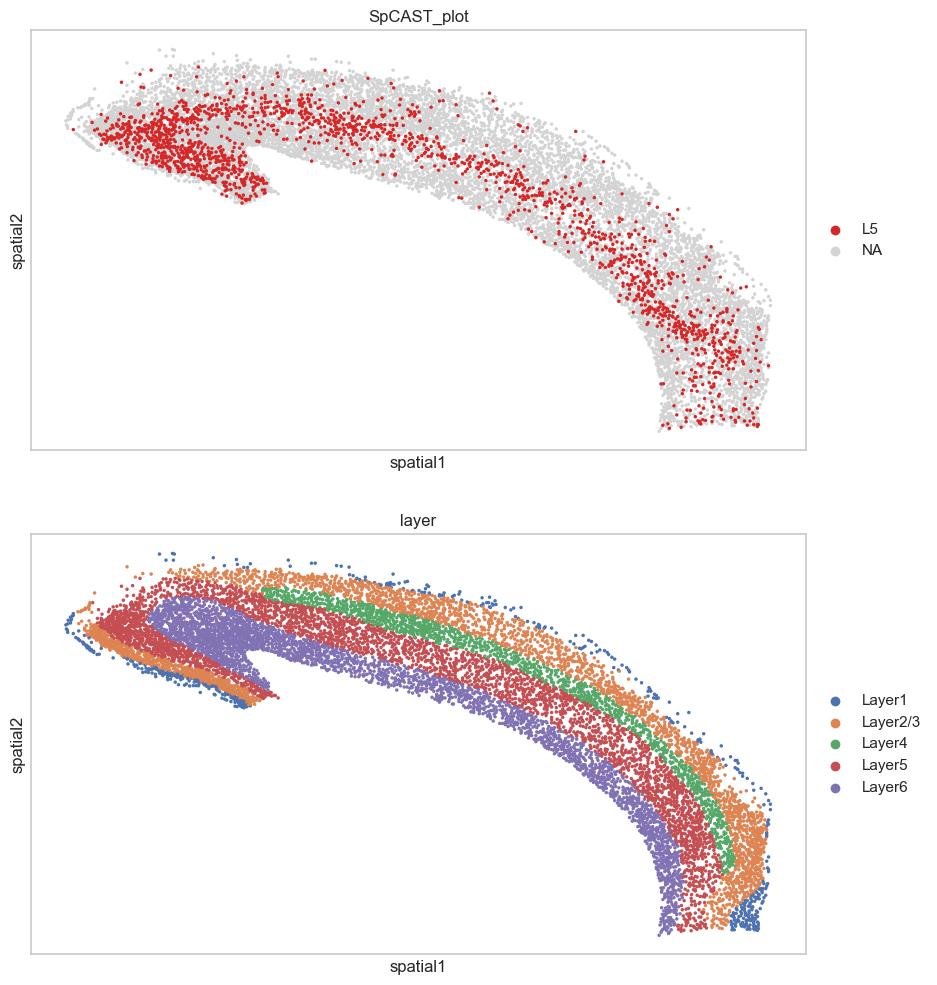

 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:01,  2.04it/s]

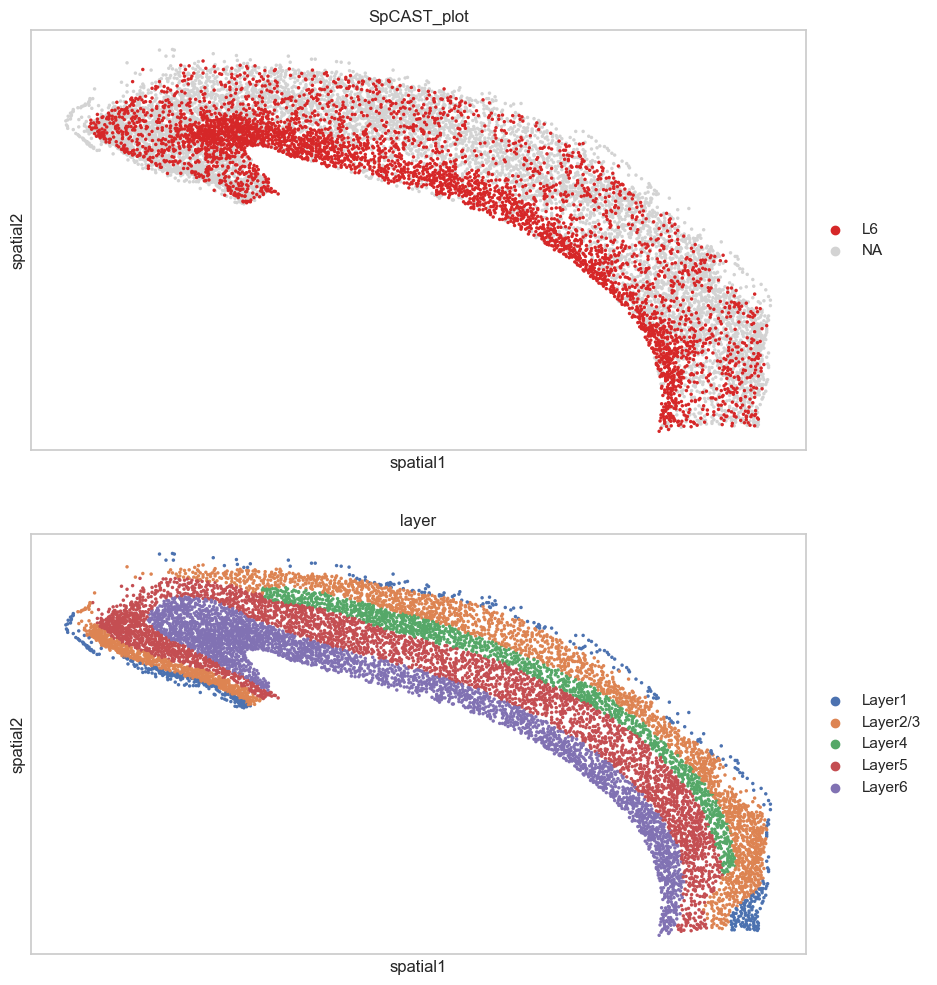

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:00,  2.05it/s]

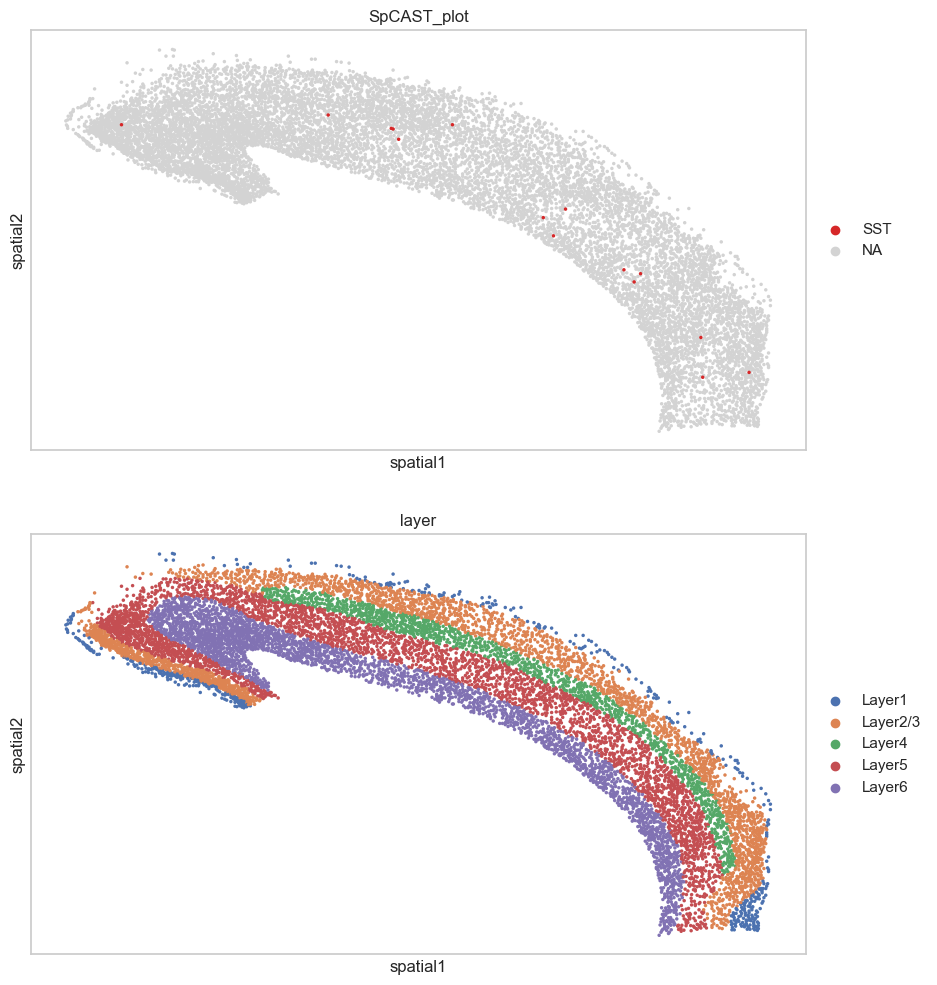

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:01<00:00,  2.08it/s]

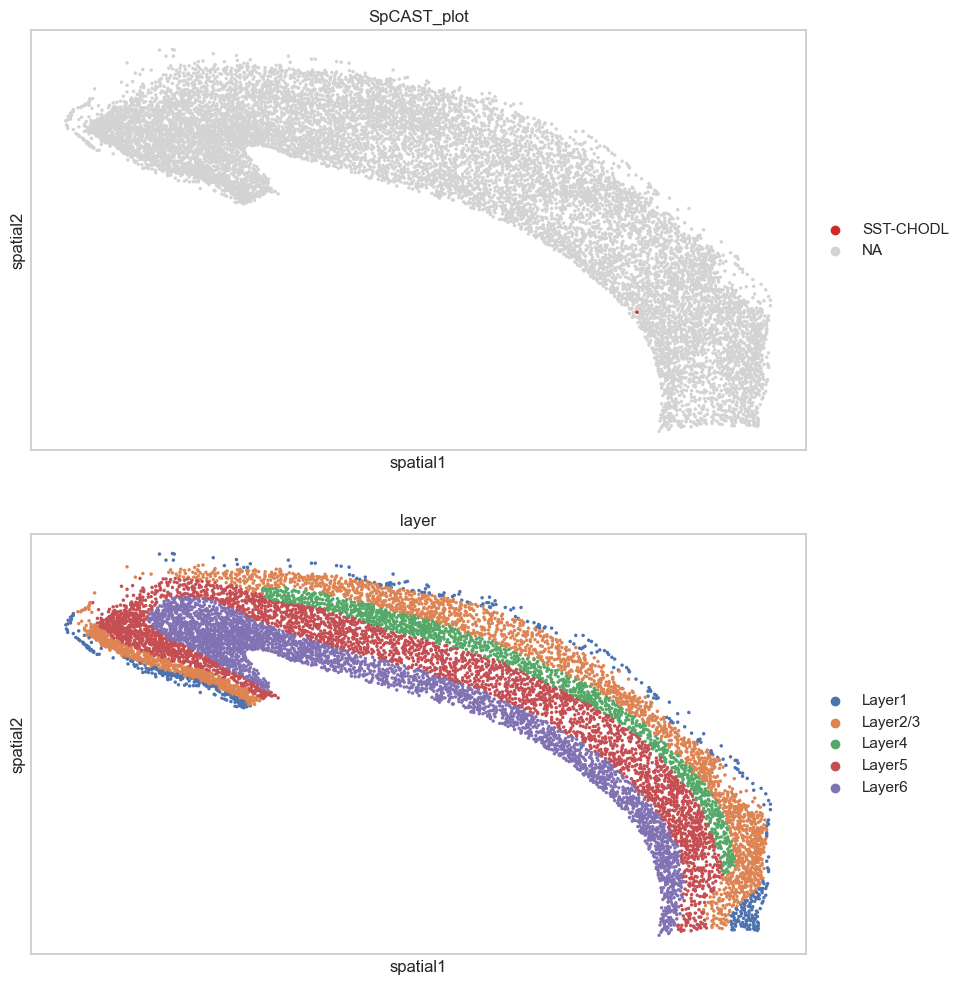

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


In [24]:
plot_layers = [
    'L2/3',
    'L5',
    'L6'
] + ["SST", "SST-CHODL"]

for plot_layer in tqdm(plot_layers):

    fig, axes = plt.subplots(2, 1, figsize=(10, 6*2))  

    spRNA_data.obs['SpCAST_plot'] = spRNA_data.obs['SpCAST_predicted'].astype(str)
    spRNA_data.obs.loc[~spRNA_data.obs['SpCAST_plot'].isin([plot_layer]), 'SpCAST_plot'] = np.NAN
    

    sc.pl.embedding(spRNA_data, basis='spatial', color=['SpCAST_plot'], ax=axes[0], palette=["#d62728"], size=25, show=False) 

    sc.pl.embedding(spRNA_data, basis='spatial', color=['layer'], ax=axes[1], size=25, show=False) 
    
    plt.show(fig)  